In [10]:
import numpy as np
import pandas as pd

from tqdm.notebook import tqdm_notebook
from kmodes.kmodes import KModes
from sklearn.cluster import KMeans
from kmodes.kprototypes import KPrototypes
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from matplotlib import gridspec
import matplotlib.pyplot as plt
import plotnine as p9
from IPython.display import display

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import warnings
warnings.filterwarnings("ignore")

### KMeans

In [4]:
# численные фичи + текстовые эмбеддиги
embeddings = pd.read_csv('../data/embeddings.csv', index_col=0)
embeddings.sample()

,MATCHED_VARIABLE_NAME_mean,EVENT_ID_mean,variable_src_in_name,MATCHED_VARIABLE_SRC_std,EVENT_ID_median,MATCHED_VARIABLE_NAME_sum,MATCHED_VARIABLE_NAME_min,MATCHED_VARIABLE_NAME_max,RESPONSE_CODE,EVENT_ID_max,MATCHED_VARIABLE_VALUE_mean,MATCHED_VARIABLE_SRC_mean,MATCHED_VARIABLE_NAME_std,MATCHED_VARIABLE_VALUE_min,MATCHED_VARIABLE_SRC_mode,MATCHED_VARIABLE_NAME_mode,MATCHED_VARIABLE_VALUE_std,bad_req_size,random_feature,MATCHED_VARIABLE_NAME_count,EVENT_ID_count,EVENT_ID_min,MATCHED_VARIABLE_VALUE_sum,MATCHED_VARIABLE_SRC_max,MATCHED_VARIABLE_SRC_sum,MATCHED_VARIABLE_SRC_median,MATCHED_VARIABLE_NAME_median,var_name_eql_value,MATCHED_VARIABLE_VALUE_median,EVENT_ID_std,bad_resp_code,MATCHED_VARIABLE_VALUE_count,MATCHED_VARIABLE_VALUE_mode,MATCHED_VARIABLE_SRC_count,MATCHED_VARIABLE_VALUE_max,EVENT_ID_mode,CLIENT_USERAGENT_count,EVENT_ID_sum,REQUEST_SIZE,MATCHED_VARIABLE_SRC_min
5088,1184.0,60.95,0,13307.179919,60.0,148000,11,25808,200,94,2334.375,5170.733333,4533.630395,29,54,132,6935.661999,0,5936,1,1,21,37350,45604,77561,55.0,132.0,0,131.5,22.977108,0,1,132,3304,28380,58,767,1219,129442,37


In [5]:
scaler = StandardScaler()
dataset_scaled = scaler.fit_transform(embeddings)
dataset_scaled.shape

(57829, 40)

In [11]:
def elbow_method_kmeans(df, space=(2,60)):

  cost = []
  n_clusters = []

  start = space[0]
  stop  = space[1]
  for k in range(start, stop):
      kmeans = KMeans(n_clusters=k, verbose=0)
      kmeans.fit(df)
      cost.append(kmeans.inertia_)
      n_clusters.append(k)


  results = pd.DataFrame(
                        {'n_clusters': n_clusters,
                        'cost': cost,
                        })
  
  
  return (p9.ggplot(results, p9.aes(x='n_clusters', y='cost'))
            + p9.geom_point()
            + p9.geom_line()
            + p9.ggtitle('Elbow Plot Kmeans'))

CPU times: user 25min 14s, sys: 8min 35s, total: 33min 50s
Wall time: 4min 40s


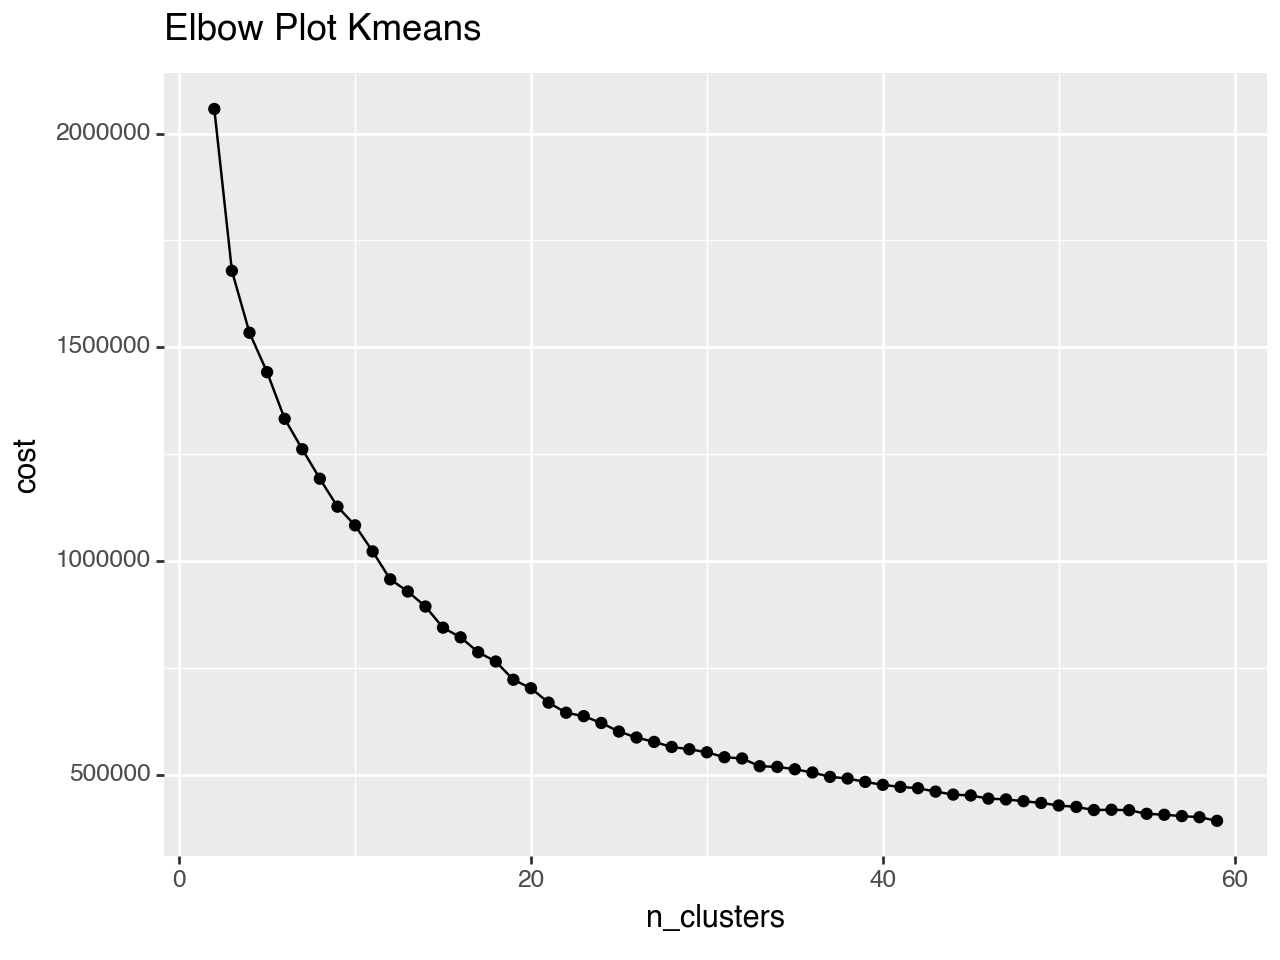

<Figure Size: (640 x 480)>

In [12]:
%%time
elbow_method_kmeans(dataset_scaled)

### KModes

In [27]:
# категориальные + численные фичи
dataset = pd.read_csv('../data/cat_num.csv')

In [13]:
def create_elbow_plot_kmodes(df, space=(2,60)):

  costs = []
  n_clusters = []
  clusters_assigned = []

  cat_cols = df.select_dtypes(include='object')
  categorical_indices = column_index(df, cat_cols.columns)
  categorical = list(categorical_indices)

  for i in tqdm_notebook(range(space[0], space[1])):

        kproto = KModes(n_clusters= i, init='Cao', verbose=0)
        clusters = kproto.fit_predict(df, categorical=categorical)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)



  results = pd.DataFrame(
                        {'n_clusters': n_clusters,
                        'cost': costs,
                        })
  
  
  return (p9.ggplot(results, p9.aes(x='n_clusters', y='cost'))
            + p9.geom_point()
            + p9.geom_line()
            + p9.ggtitle('Elbow Plot Kmodes'))
  

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

  0%|          | 0/58 [00:00<?, ?it/s]

CPU times: user 3h 47min 15s, sys: 1min 38s, total: 3h 48min 53s
Wall time: 3h 48min 15s


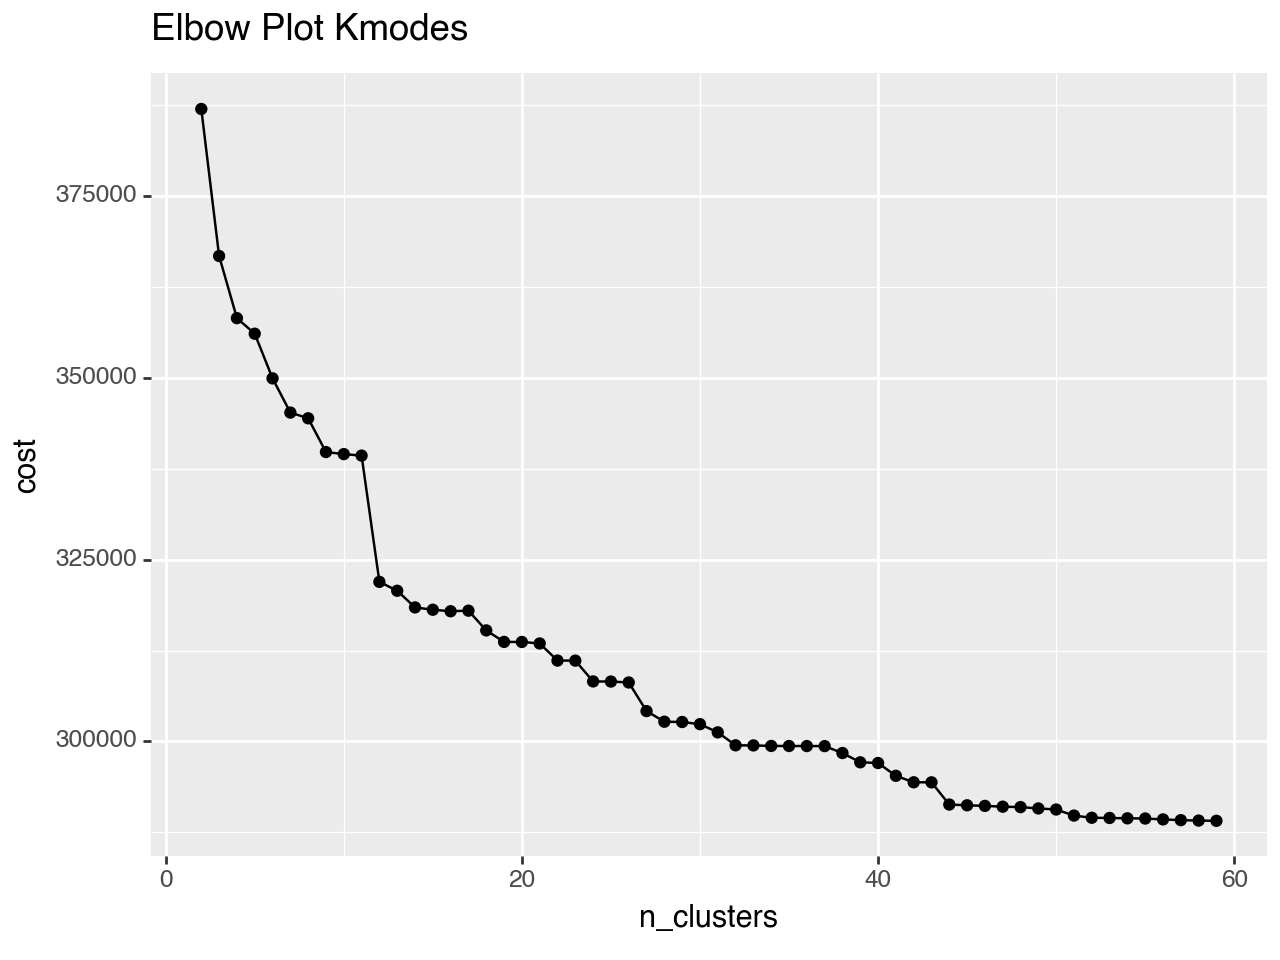

<Figure Size: (640 x 480)>

In [28]:
%%time
create_elbow_plot_kmodes(dataset)

### K-Prototype

In [29]:
# категориальные + численные фичи
dataset = pd.read_csv('../data/cat_num.csv')
dataset.sample()

,CLIENT_IP,CLIENT_USERAGENT,REQUEST_SIZE,RESPONSE_CODE,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID,var_name_eql_value,variable_src_in_name,bad_req_size,bad_resp_code
26394,106.2.231.5,Mozilla/5.0 (iPhone; CPU iPhone OS 11_2_1 like...,1436,200,REQUEST_PATH,REQUEST_PATH,/mail/bjs/sxu.nsf/($Inbox)/27aa72d46536e200802...,ncbk_mMBjksgoq1eKDBh,0,1,0,0


In [46]:
def calculate_zscore(df, columns):
  '''
  scales columns in dataframe using z-score
  '''
  df = df.copy()
  for col in columns:
      df[col] = (df[col] - df[col].mean())/df[col].std(ddof=0)

  return df

def create_elbow_plot(df, categorical, space=(2,60)):

  costs = []
  n_clusters = []
  clusters_assigned = []
  print(categorical)

  for i in tqdm_notebook(range(space[0], space[1])):

        kproto = KPrototypes(n_clusters= i, init='Cao', verbose=0)
        clusters = kproto.fit_predict(df, categorical=categorical)
        costs.append(kproto.cost_)
        n_clusters.append(i)
        clusters_assigned.append(clusters)



  results = pd.DataFrame(
                        {'n_clusters': n_clusters,
                        'cost': costs,
                        })
  
  
  return (p9.ggplot(results, p9.aes(x='n_clusters', y='cost'))
            + p9.geom_point()
            + p9.geom_line()
            + p9.ggtitle('Elbow Plot'))
  

def column_index(df, query_cols):
    cols = df.columns.values
    sidx = np.argsort(cols)
    return sidx[np.searchsorted(cols,query_cols,sorter=sidx)]

In [34]:
k_protype_data = dataset.copy()

numeric_cols = k_protype_data.select_dtypes(include=np.number)
cat_cols = k_protype_data.select_dtypes(include='object')

norm_num_cols = calculate_zscore(numeric_cols, numeric_cols)
processed_df = pd.concat([norm_num_cols, cat_cols], axis=1)

processed_df.head(2)

,REQUEST_SIZE,RESPONSE_CODE,var_name_eql_value,variable_src_in_name,bad_req_size,bad_resp_code,CLIENT_IP,CLIENT_USERAGENT,MATCHED_VARIABLE_SRC,MATCHED_VARIABLE_NAME,MATCHED_VARIABLE_VALUE,EVENT_ID
0,-0.050080,1.047226,-0.10039,-1.624532,-0.041411,-0.041411,188.138.92.55,Неизвестно,REQUEST_URI,Неизвестно,//tmp/20160925122692indo.php.vob,AVdhXFgVq1Ppo9zF5Fxu
1,-0.047721,0.021402,-0.10039,-1.624532,-0.041411,-0.041411,93.158.215.131,Mozilla/5.0 (Windows NT 6.3; WOW64; rv:45.0) G...,REQUEST_GET_ARGS,url,http://www.galitsios.gr/?option=com_k2,AVdcJmIIq1Ppo9zF2YIp


In [44]:
categorical_indices = list(column_index(processed_df, categorical))
categorical_indices

[6, 7, 8, 9, 10, 11]

In [ ]:
%%time
create_elbow_plot(df=processed_df, categorical=categorical_indices, space=(2,60))

[6, 7, 8, 9, 10, 11]


  0%|          | 0/10 [00:00<?, ?it/s]